In [1]:
import torch
import xarray
from datasets import *
from models import *
from dl_pipeline import *
import seaborn
import numpy as np
import matplotlib.pyplot as plt
import copy

In [2]:
train_json_path = '/g/data/x77/ob2720/partition/train.json'
valid_json_path = '/g/data/x77/ob2720/partition/valid.json'
test_json_path = '/g/data/x77/ob2720/partition/test.json'

## Perturbation of Eigenvalues for Synthesis

We start with perturbation of the eigenvectors for synthesising new data from eiegenvalues closest to $0$. We take this perturbation to be sampled from a random distribution around a mean, $\mu$, of $0$, with a standard deviation of $\sigma$.

In [3]:
mu, sigma = 0, 0.001 # mean and standard deviation

In [4]:
train_ds, valid_ds, test_ds = generate_prediction_dataset()

191235


In [6]:
def new_example(model,x, perturb=True, sigma=0.001):
    W = model.dynamics.dynamics.weight.cpu().detach().numpy()
    w, v = np.linalg.eig(W)
    min_i = np.argmin(w)
    s = np.random.normal(mu, sigma, len(v[0]))
    
    model_modified = copy.deepcopy(model).to(0)
    
    
    if perturb:
        v[min_i] += s
    W_1 = reconstruct_operator(w,v).real
    
    model_modified.dynamics.dynamics.weight = torch.nn.Parameter(torch.from_numpy(W_1))
    
    model_modified.to(0)
    x_modified = model_modified(x.to(0))
    
    return x_modified

In [8]:
saved_models_path = '/home/156/cn1951/kae-cyclones/saved_models'

model_dae = koopmanAE(32, steps=4, steps_back=4, alpha=8).to(0)
model_dae.load_state_dict(torch.load(f'{saved_models_path}/dae-model-continued-0.4210312087978713.pt'))
model_dae.to(0)

koopmanAE(
  (encoder): encoderNetSimple(
    (fc1): Linear(in_features=400, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=128, bias=True)
    (fc3): Linear(in_features=128, out_features=32, bias=True)
  )
  (decoder): decoderNetSimple(
    (fc1): Linear(in_features=32, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=128, bias=True)
    (fc3): Linear(in_features=128, out_features=400, bias=True)
  )
  (dynamics): dynamics(
    (dynamics): Linear(in_features=32, out_features=32, bias=False)
  )
  (backdynamics): dynamics_back(
    (dynamics): Linear(in_features=32, out_features=32, bias=False)
  )
)

(20, 20)


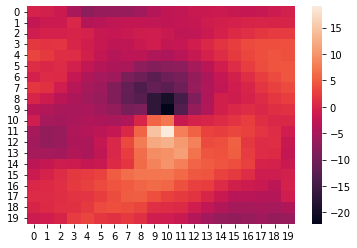

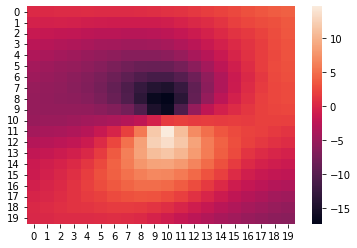

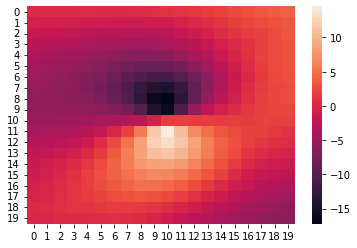

In [9]:
x_reg = new_example(model_dae,train_ds[130][0].to(0), True, sigma=0.1)[0][0].squeeze(0).squeeze(0).cpu().detach().numpy()
x_per = new_example(model_dae,train_ds[130][0].to(0), False, sigma=2)[0][0].squeeze(0).squeeze(0).cpu().detach().numpy()
print(x_reg.shape)
old = train_ds[131][0].squeeze(0).squeeze(0)
seaborn.heatmap(old)
plt.show()
seaborn.heatmap(x_reg)
plt.show()
seaborn.heatmap(x_per)
plt.show()

### Generation of New Data

In [11]:
def create_modified_model(model, mu, sigma, perturb=True):
    W = model.dynamics.dynamics.weight.cpu().detach().numpy()
    w, v = np.linalg.eig(W)
    min_i = np.argmin(w)
    
    model_modified = copy.deepcopy(model).to(0)
    
    s = np.random.normal(mu, sigma, len(v[0]))
    
    if perturb:
        v[min_i] += s
    W_1 = reconstruct_operator(w,v).real
    
    model_modified.to(0)
    model_modified.dynamics.dynamics.weight = torch.nn.Parameter(torch.from_numpy(W_1))
    
    return model_modified

In [12]:
mod_model = create_modified_model(model_dae, 0, 0.1).to(0)

In [21]:
def generate_new_data(model, modified_model, sigma):   
    
    
    train_ds = CycloneDataset('/g/data/x77/ob2720/partition/train/', tracks_path=train_json_path, 
                                            save_np=True, load_np=False)
    val_ds = CycloneDataset('/g/data/x77/ob2720/partition/valid/', tracks_path=valid_json_path, 
                                        save_np=True, load_np=False, partition_name='valid')
    test_ds = CycloneDataset('/g/data/x77/ob2720/partition/test/', tracks_path=test_json_path,
                                         save_np=True, load_np=False, partition_name='test')
    print(len(train_ds))
    print("Train ds")
    # for i,(cyclone_array, cyclone, j) in tqdm(enumerate(train_ds)):
    #     x_reg = model(torch.from_numpy(cyclone_array).to(0))[0][0].cpu().detach().numpy()
    #     np.save(f'/g/data/x77/jm0124/synthetic_datasets/base_synthesis/u/2/{sigma}/train/{cyclone}-{j+1}', x_reg)
    
    for i,(cyclone_array, cyclone, j) in tqdm(enumerate(train_ds)):    
        x_mod = modified_model(torch.from_numpy(cyclone_array).to(0))[0][0].cpu().detach().numpy()
        np.save(f'/g/data/x77/cn1951/synthetic_datasets/normal_perturb_synthesis/u/2/{sigma}/train/{cyclone}-{j+1}', x_mod)

In [22]:
generate_new_data(model_dae, mod_model, '0.1')

191235
Train ds


0it [00:00, ?it/s]


FileNotFoundError: [Errno 2] No such file or directory: '/g/data/x77/cn1951/synthetic_datasets/normal_perturb_synthesis/u/2/0.1/train/1999258N25128-2.npy'

In [14]:
print(train_ds[130][0].shape)

torch.Size([1, 1, 20, 20])


In [23]:
data = np.load('/g/data/x77/jm0124/synthetic_datasets/normal_perturb_synthesis/u/2/train/1999258N25128-3.npy')
data2 = np.load('/g/data/x77/jm0124/synthetic_datasets/base_synthesis/u/2/train/1999258N25128-3.npy')

FileNotFoundError: [Errno 2] No such file or directory: '/g/data/x77/jm0124/synthetic_datasets/normal_perturb_synthesis/u/2/train/1999258N25128-3.npy'